In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from datetime import timedelta
from haversine import haversine

# I. Model without Spray and Weather using RF

In [2]:
df_train = pd.read_csv('train.csv')
df_spray = pd.read_csv('spray.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train['DateC'] = pd.to_datetime(df_train['Date'])
df_test['DateC'] = pd.to_datetime(df_test['Date'])
df_spray['DateC'] = pd.to_datetime(df_spray['Date'])

In [4]:
df_train['is_Species'] = 0
df_train.loc[((df_train['Species'] == 'CULEX PIPIENS/RESTUANS') | (df_train['Species'] == 'CULEX PIPIENS') \
       | (df_train['Species'] == 'CULEX RESTUANS')), ['is_Species']] = 1

In [5]:
df_train = df_train[df_train['is_Species'] == 1]

In [6]:
df_train_gp = df_train.groupby(['DateC','Trap']).agg({'Latitude':np.mean,'Longitude':np.mean, 'NumMosquitos':np.sum, 'WnvPresent':np.max})

In [7]:
# df_train_gp['Spray'] = 0
df_train_gp = df_train_gp.reset_index()

# df_test_gp['Spray'] = 0
# df_test_gp = df_test_gp.reset_index()
df_test_gp = df_test.copy()

In [8]:
df_train_gp.shape, df_test.shape, df_spray.shape

((4590, 6), (116293, 12), (14835, 5))

In [9]:
# Get training data before spraying was done
df_train_gp_fil = df_train_gp[df_train_gp['DateC'] < df_spray['DateC'].min()]
df_test_gp_fil = df_test.copy()

In [10]:
df_train_gp_fil['WnvPresent'].value_counts()

0    2954
1     195
Name: WnvPresent, dtype: int64

In [11]:
df_train_gp_fil['Year'] = df_train_gp_fil['DateC'].dt.year
df_train_gp_fil['Month'] = df_train_gp_fil['DateC'].dt.month

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
df_test_gp_fil['Year'] = df_test_gp_fil['DateC'].dt.year
df_test_gp_fil['Month'] = df_test_gp_fil['DateC'].dt.month

In [13]:
df_train_gp_fil.head()

,DateC,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month
0,2007-05-29,T002,41.954690,-87.800991,2,0,2007,5
1,2007-05-29,T007,41.994991,-87.769279,1,0,2007,5
2,2007-05-29,T015,41.974089,-87.824812,5,0,2007,5
3,2007-05-29,T045,41.921600,-87.666455,2,0,2007,5
4,2007-05-29,T046,41.891118,-87.654491,1,0,2007,5


In [14]:
df_test_gp_fil.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,DateC,Year,Month
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008-06-11,2008,6
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008-06-11,2008,6
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008-06-11,2008,6
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008-06-11,2008,6
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008-06-11,2008,6


In [15]:
df_train_gp_fil = pd.get_dummies(df_train_gp_fil, columns=['Trap'], drop_first=True)

In [16]:
df_test_gp_fil = pd.get_dummies(df_test_gp_fil, columns=['Trap'], drop_first=True)

In [17]:
# Update X and y
cols = list(df_train_gp_fil.columns.values)
cols.remove('DateC')
cols.remove('NumMosquitos')
cols.remove('WnvPresent')

In [18]:
# Change the X values into DataFrame format
X_Train = df_train_gp_fil[cols]
X_Test = df_test_gp_fil[cols]
y_Train = df_train_gp_fil['WnvPresent']

In [19]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [20]:
clf = RandomForestClassifier()
clf.fit(X_Train, y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
model1_fi_df = pd.DataFrame(data=clf.feature_importances_, index=X_Train.columns.T, columns=['FI1'])

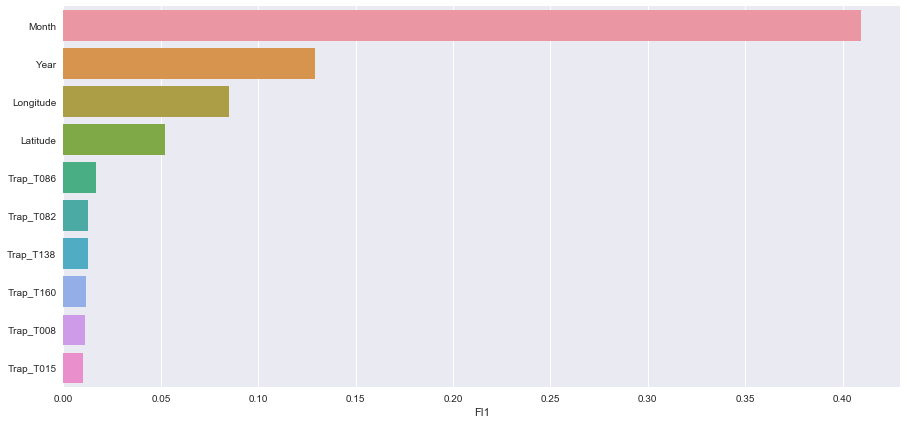

In [403]:
# Plot the Features sorted by decreasing importance
sns.set(rc={'figure.figsize':(15,7)})
model1_fi_df = model1_fi_df[model1_fi_df['FI1'] > 0].sort_values(by='FI1', ascending=False)
model1_fi_df = model1_fi_df.head(10)
sns.barplot(y=model1_fi_df.index, 
            x=model1_fi_df['FI1'])

In [23]:
y_Pred = clf.predict(X_Test)
predictions = [round(value) for value in y_Pred]
print("Accuracy: %.2f%%" % (clf.score(X_Test, y_Pred) * 100.0))

Accuracy: 100.00%


In [24]:
y_Prob = np.array(clf.predict_proba(X_Test))[:,1]

In [25]:
df_model1_output = pd.DataFrame(y_Prob).reset_index()
df_model1_output.columns = ['Id', 'WnvPresent']
df_model1_output.to_csv('Prediction_NoSprayNoWeather.csv', index=False)

# II. Model without Spray using RF

In [361]:
# df_trainweather = pd.read_csv('train_weathernospray.csv')
# df_testweather =pd.read_csv('test_weathernospray.csv')

df_trainweather = pd.read_csv('train_weathernosprayspecies.csv')
df_testweather =pd.read_csv('test_weathernosprayspecies.csv')

In [362]:
df_trainweather.shape, df_testweather.shape

((10506, 27), (116293, 25))

In [363]:
df_trainweather.drop(columns=['Unnamed: 0'], inplace=True, axis=1)
df_trainweather.drop(columns=['Species'], inplace=True, axis=1)
df_trainweather.drop(columns=['CodeSum'], inplace=True, axis=1)
df_trainweather.drop(columns=['Depth'], inplace=True, axis=1)
df_trainweather.drop(columns=['SeaLevel'], inplace=True, axis=1)
df_trainweather.drop(columns=['AddressAccuracy'], inplace=True, axis=1)

In [364]:
df_testweather.drop(columns=['Unnamed: 0'], inplace=True, axis=1)
df_testweather.drop(columns=['CodeSum'], inplace=True, axis=1)
df_testweather.drop(columns=['Depth'], inplace=True, axis=1)
df_testweather.drop(columns=['SeaLevel'], inplace=True, axis=1)
df_testweather.drop(columns=['Id'], inplace=True, axis=1)
df_testweather.drop(columns=['AddressAccuracy'], inplace=True, axis=1)

In [365]:
df_trainweather.head()

,Date,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,is_Species,Month,Year,Temp_Min,...,Temp_Avg,Temp_Dew_Point,Temp_Wet_Bulb,Heat,Cool,PrecipTotal,StnPressure,AvgSpeed,ResultDir,ResultSpeed
0,2007-05-29,T002,41.954690,-87.800991,1,0,1,5,2007,62.5,...,75.5,58.5,65.5,0.0,10.5,0.0,29.415,6.95,17.0,5.8
1,2007-05-29,T002,41.954690,-87.800991,1,0,1,5,2007,62.5,...,75.5,58.5,65.5,0.0,10.5,0.0,29.415,6.95,17.0,5.8
2,2007-05-29,T007,41.994991,-87.769279,1,0,1,5,2007,62.5,...,75.5,58.5,65.5,0.0,10.5,0.0,29.415,6.95,17.0,5.8
3,2007-05-29,T015,41.974089,-87.824812,1,0,1,5,2007,62.5,...,75.5,58.5,65.5,0.0,10.5,0.0,29.415,6.95,17.0,5.8
4,2007-05-29,T015,41.974089,-87.824812,4,0,1,5,2007,62.5,...,75.5,58.5,65.5,0.0,10.5,0.0,29.415,6.95,17.0,5.8


In [366]:
df_testweather.head()

,Date,Trap,Latitude,Longitude,is_Species,Month,Year,Temp_Min,Temp_Max,Temp_Avg,Temp_Dew_Point,Temp_Wet_Bulb,Heat,Cool,PrecipTotal,StnPressure,AvgSpeed,ResultDir,ResultSpeed
0,2008-06-11,T002,41.95469,-87.800991,1,6,2008,63.5,86.0,75.0,55.5,64.0,0.0,10.0,0.0,29.31,10.2,18.0,9.15
1,2008-06-11,T002,41.95469,-87.800991,1,6,2008,63.5,86.0,75.0,55.5,64.0,0.0,10.0,0.0,29.31,10.2,18.0,9.15
2,2008-06-11,T002,41.95469,-87.800991,1,6,2008,63.5,86.0,75.0,55.5,64.0,0.0,10.0,0.0,29.31,10.2,18.0,9.15
3,2008-06-11,T002,41.95469,-87.800991,0,6,2008,63.5,86.0,75.0,55.5,64.0,0.0,10.0,0.0,29.31,10.2,18.0,9.15
4,2008-06-11,T002,41.95469,-87.800991,0,6,2008,63.5,86.0,75.0,55.5,64.0,0.0,10.0,0.0,29.31,10.2,18.0,9.15


In [367]:
df_trainweather.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent',
       'is_Species', 'Month', 'Year', 'Temp_Min', 'Temp_Max', 'Temp_Avg',
       'Temp_Dew_Point', 'Temp_Wet_Bulb', 'Heat', 'Cool', 'PrecipTotal',
       'StnPressure', 'AvgSpeed', 'ResultDir', 'ResultSpeed'],
      dtype='object')

In [368]:
# df_trainweather.columns = ['Date', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent',
#        'Temp_Min', 'Temp_Max', 'Temp_Avg', 'Temp_Dew_Point', 'Temp_Wet_Bulb',
#        'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'AvgSpeed', 'ResultDir',
#        'ResultSpeed', 'PrecipTotal7']

In [369]:
df_testweather.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'is_Species', 'Month', 'Year',
       'Temp_Min', 'Temp_Max', 'Temp_Avg', 'Temp_Dew_Point', 'Temp_Wet_Bulb',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'AvgSpeed', 'ResultDir',
       'ResultSpeed'],
      dtype='object')

In [370]:
# df_testweather.columns = ['Date', 'Trap', 'Latitude', 'Longitude', 'Temp_Min', 'Temp_Max',
#        'Temp_Avg', 'Temp_Dew_Point', 'Temp_Wet_Bulb', 'Heat', 'Cool',
#        'PrecipTotal', 'StnPressure', 'AvgSpeed', 'ResultDir', 'ResultSpeed',
#        'PrecipTotal7']

In [371]:
# df_trainweather['DateC'] = pd.to_datetime(df_trainweather['Date'])

#0.59
# df_trainweather_gp = df_trainweather.groupby(['DateC','Trap']).agg({'Latitude':np.mean,'Longitude':np.mean, 
#                                                                     'NumMosquitos':np.sum, 'WnvPresent':np.max, 
#                                                                     'Temp_Min':np.mean, 'Temp_Avg':np.mean, 
#                                                                     'Temp_Dew_Point':np.mean, 'Temp_Wet_Bulb':np.mean,
#                                                                     'Heat':np.mean, 'Cool':np.mean,
#                                                                     'PrecipTotal':np.mean, 'StnPressure':np.mean,
#                                                                     'AvgSpeed':np.mean, 
#                                                                     'ResultDir':np.mean, 'ResultSpeed':np.mean, 
#                                                                     'PrecipTotal7':np.mean})

#0.64
# df_trainweather_gp = df_trainweather.groupby(['DateC','Trap']).agg({'Latitude':np.mean,'Longitude':np.mean, 
#                                                                     'NumMosquitos':np.sum, 'WnvPresent':np.max, 
#                                                                     'Temp_Min':np.mean, 'Temp_Avg':np.mean, 
#                                                                     'Temp_Dew_Point':np.mean, 'Temp_Wet_Bulb':np.mean,
#                                                                     'Heat':np.mean, 'Cool':np.mean,
#                                                                     'PrecipTotal':np.mean, 'StnPressure':np.mean,
#                                                                     'AvgSpeed':np.mean, 
#                                                                     'ResultDir':np.mean, 'ResultSpeed':np.mean})
# df_trainweather_gp = df_trainweather_gp.reset_index()

df_trainweather_gp = df_trainweather.copy()

In [372]:
# df_testweather['DateC'] = pd.to_datetime(df_testweather['Date'])

In [373]:
df_trainweather_gp = df_trainweather_gp[df_trainweather_gp['Date'] > df_spray['Date'].min()]

In [377]:
df_trainweather_gp['Date'] = pd.to_datetime(df_trainweather_gp['Date'])

In [378]:
df_testweather['Date'] = pd.to_datetime(df_testweather['Date'])

In [379]:
df_trainweather_gp['Day'] = df_trainweather_gp['Date'].dt.day
df_testweather['Day'] = df_testweather['Date'].dt.day

In [380]:
df_trainweather_gp.shape, df_testweather.shape

((2932, 22), (116293, 20))

In [381]:
# df_trainweather_gp['Year'] = df_trainweather_gp['DateC'].dt.year
# df_trainweather_gp['Month'] = df_trainweather_gp['DateC'].dt.month

In [382]:
# df_testweather['Year'] = df_testweather['DateC'].dt.year
# df_testweather['Month'] = df_testweather['DateC'].dt.month

In [383]:
df_trainweather_gp['Trap'].nunique(), df_testweather['Trap'].nunique()

(80, 149)

In [384]:
# Drop the Trap column for now and generate predictions
# df_trainweather.drop(columns=['Trap'], inplace=True, axis=1)
# df_testweather.drop(columns=['Trap'], inplace=True, axis=1)

# df_trainweather_gp_fil = df_trainweather.copy()
# df_testweather_gp_fil = df_testweather.copy()

In [385]:
df_trainweather_gp_fil = pd.get_dummies(df_trainweather_gp, columns=['Trap'], drop_first=True)

In [386]:
df_testweather_gp_fil = pd.get_dummies(df_testweather, columns=['Trap'], drop_first=True)

In [387]:
for column in df_testweather_gp_fil.columns.values.tolist():
    if column not in df_trainweather_gp_fil.columns.values.tolist():
        df_trainweather_gp_fil[column] = 0

In [388]:
# Get Column Names
cols = list(df_trainweather_gp_fil.columns.values)
cols.remove('Date')
cols.remove('NumMosquitos')
cols.remove('WnvPresent')

In [389]:
# Change the X values into DataFrame format
X_Train = df_trainweather_gp_fil[cols]
X_Test = df_testweather_gp_fil[cols]
y_Train = df_trainweather_gp_fil['WnvPresent']

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


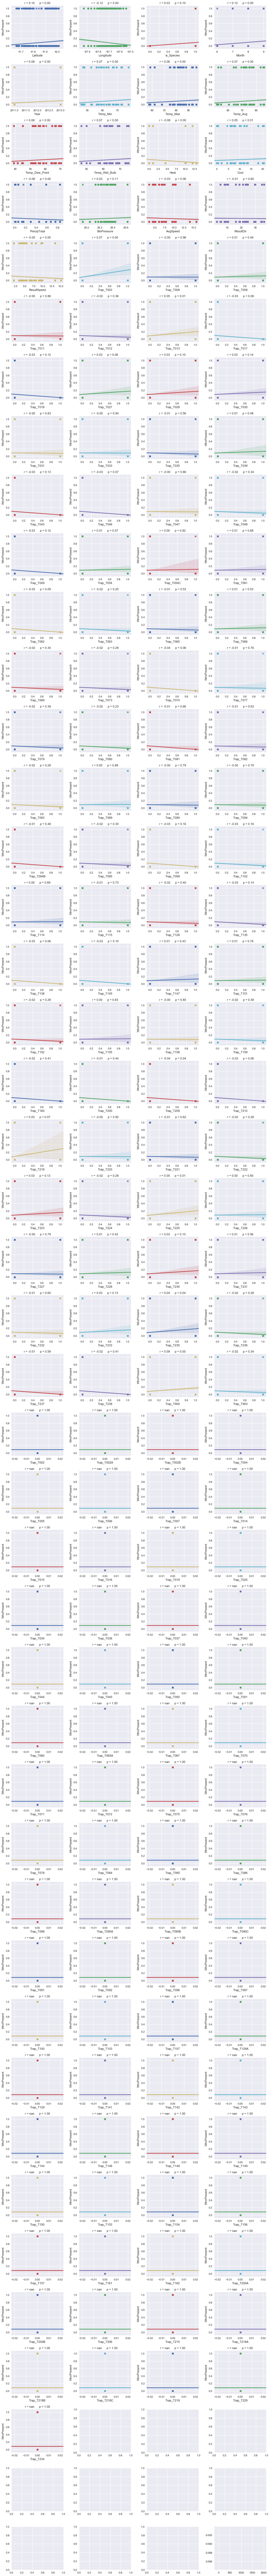

In [343]:
# Plot the correlations and p of numerical values vs Sale Condition Abnormal
import scipy.stats as stats
nr_rows = 44
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_plot_num_feats = X_Train.columns.T

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(X_Train[li_plot_num_feats[i]], y_Train, ax = axs[r][c])
            stp = stats.pearsonr(X_Train[li_plot_num_feats[i]], y_Train)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

In [390]:
X_Train.columns

Index(['Latitude', 'Longitude', 'is_Species', 'Month', 'Year', 'Temp_Min',
       'Temp_Max', 'Temp_Avg', 'Temp_Dew_Point', 'Temp_Wet_Bulb',
       ...
       'Trap_T200A', 'Trap_T200B', 'Trap_T206', 'Trap_T215', 'Trap_T218A',
       'Trap_T218B', 'Trap_T218C', 'Trap_T219', 'Trap_T229', 'Trap_T234'],
      dtype='object', length=166)

In [391]:
X_Test.columns

Index(['Latitude', 'Longitude', 'is_Species', 'Month', 'Year', 'Temp_Min',
       'Temp_Max', 'Temp_Avg', 'Temp_Dew_Point', 'Temp_Wet_Bulb',
       ...
       'Trap_T200A', 'Trap_T200B', 'Trap_T206', 'Trap_T215', 'Trap_T218A',
       'Trap_T218B', 'Trap_T218C', 'Trap_T219', 'Trap_T229', 'Trap_T234'],
      dtype='object', length=166)

In [392]:
X_Train.isna().any().any()

False

In [232]:
# X_Train['PrecipTotal'].fillna(0, inplace=True)

In [393]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier()
clf.fit(X_Train, y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [394]:
model2_fi_df = pd.DataFrame(data=clf.feature_importances_, index=X_Train.columns.T, columns=['FI2'])

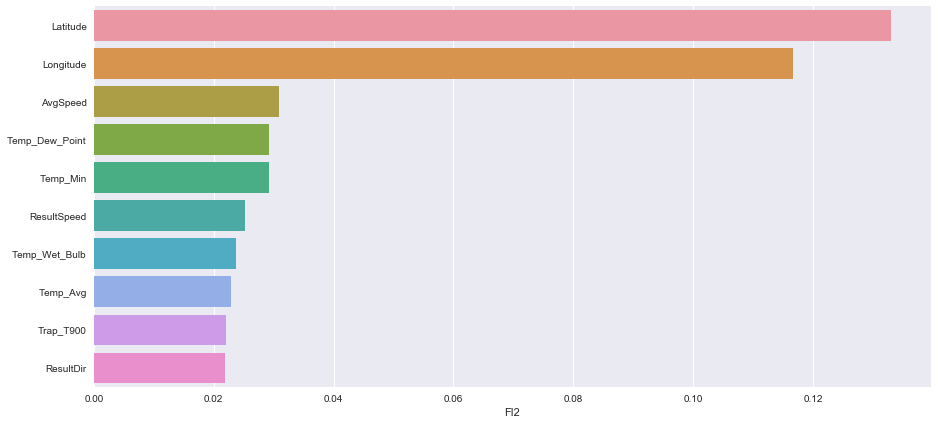

In [405]:
# Plot the Features sorted by decreasing importance
sns.set(rc={'figure.figsize':(15,7)})
model2_fi_df = model2_fi_df[model2_fi_df['FI2'] > 0].sort_values(by='FI2', ascending=False)
model2_fi_df = model2_fi_df.head(10)
sns.barplot(y=model2_fi_df.index, 
            x=model2_fi_df['FI2'])

In [397]:
X_Test['PrecipTotal'].fillna(0, inplace=True)

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [398]:
y_Pred = clf.predict(X_Test)
predictions = [round(value) for value in y_Pred]
print("Accuracy: %.2f%%" % (clf.score(X_Test, y_Pred) * 100.0))

Accuracy: 100.00%


In [399]:
y_Prob = np.array(clf.predict_proba(X_Test))[:,1]

df_model1_output = pd.DataFrame(y_Prob).reset_index()
df_model1_output.columns = ['Id', 'WnvPresent']
df_model1_output.to_csv('Prediction_NoSpraySpecies.csv', index=False)

In [337]:
# Use SMOTE first and do Random Forest
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_Res, y_Res = sm.fit_sample(X_Train, y_Train)

In [338]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(X_Res, y_Res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [339]:
y_Prob = np.array(clf_rf.predict_proba(X_Test))[:,1]

df_model1_output = pd.DataFrame(y_Prob).reset_index()
df_model1_output.columns = ['Id', 'WnvPresent']
df_model1_output.to_csv('Prediction_NoSpraySMOTE.csv', index=False)

In [251]:
y_Prob = np.array(clf_rf.predict(X_Test))
pd.DataFrame(y_Prob).join(X_Test)


,0,Latitude,Longitude,Temp_Min,Temp_Avg,Temp_Dew_Point,Temp_Wet_Bulb,Heat,Cool,PrecipTotal,...,Trap_T200A,Trap_T200B,Trap_T206,Trap_T215,Trap_T218A,Trap_T218B,Trap_T218C,Trap_T219,Trap_T229,Trap_T234
0,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
1,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
2,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
3,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
4,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
5,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
6,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
7,0,41.954690,-87.800991,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
8,0,41.994991,-87.769279,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0
9,0,41.994991,-87.769279,63.5,75.0,55.5,64.0,0.0,10.0,0.00,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_spray['DateC'].plot()

In [ ]:
for index_spray, row_spray in df_spray.iterrows():
    for index_train, row_train in df_train_gp.iterrows():
        distance = haversine((row_train['Latitude'], row_train['Longitude']),
                             (row_spray['Latitude'], row_spray['Longitude']), miles=False)
        daydelta = row_train['DateC'] - row_spray['DateC']
        daydelta = daydI'm not elta.days
        
        if (distance <= 1 & daydelta <= 7):
            df_train_gp.loc[index_train,'Spray'] = df_train_gp.loc[index_train,'Spray'] + 1

In [ ]:
df_test = pd.read_csv('test.csv')
df_test.head()

In [ ]:
df_spray = pd.read_csv('spray.csv')
df_spray.head()

In [ ]:
plt.scatter(df_spray['Latitude'], df_spray['Longitude'])

In [ ]:
df_weather = pd.read_csv('weather.csv')
df_weather.head()

In [ ]:
df_train.shape, df_test.shape, df_spray.shape, df_weather.shape

In [ ]:
# Plot the distribution of mosquitos based on longitude and latitude
plt.figure(figsize=(20,15))
plt.scatter(df_spray['Latitude'], df_spray['Longitude'], c='r')
plt.scatter(df_train['Latitude'], df_train['Longitude'])

In [ ]:
# Plot the distribution of mosquitos based on longitude and latitude
plt.figure(figsize=(20,15))
plt.scatter(df_spray['Latitude'], df_spray['Longitude'], c='r')
plt.scatter(df_test['Latitude'], df_test['Longitude'])

In [ ]:
df_train.columns

In [ ]:
df_weather.columns

In [ ]:
df_spray.columns

In [ ]:
df_spray.info()

In [ ]:
df_train.info()

In [ ]:
df_train.columns[df_train.isnull().any()]

In [ ]:
df_test.columns[df_test.isnull().any()]

In [ ]:
df_spray.columns[df_spray.isnull().any()]
#drop the time later on

In [ ]:
df_weather.columns[df_weather.isnull().any()]

In [ ]:
df_spray = df_spray.drop(columns='Time', axis=1)

In [ ]:
df_spray['Sprayed'] = 1

In [ ]:
df_combined = pd.merge(df_train, df_spray, on=['Date', 'Latitude', 'Longitude'], how='outer')
#df_combined = pd.merge(df_combined, df_weather, on=['Date'], how='outer')
df_combined

In [ ]:
df_combined2 = pd.merge(df_train, df_spray, on=['Date'], how='outer')
#df_combined2 = pd.merge(df_combined2, df_weather, on=['Date'], how='outer')
df_combined2

In [ ]:
df_train['Date'].value_counts()

In [ ]:
# Get a lat and long for each trap
trap_locs = df_train.groupby(['Date','Trap'], as_index=False)['Latitude', 'Longitude'].mean().dropna().reset_index().drop('index', 1)
trap_locs

In [ ]:
trap_name = np.array(trap_locs.Trap)
trap_lat = np.array(trap_locs.Latitude)
trap_lon = np.array(trap_locs.Longitude)